In [1]:
from enrichment_functions import * 

import matplotlib.pyplot as plt
from draw_wordcloud import draw_word_cloud

from Bio import SeqIO

import json
import gzip

## Datasets

* [Original dataset](#original)
* [Architectures datasets](#architectures)
* [PDB network dataset](#pdbnetwork)
* [String dataset](#string)

### Parse GO files

In [2]:
# file containing gene ontology
GO_FILE_PATH = "../../data/go.json.gz"

# file containin HUMAN GO annotations
MAP_FILE_PATH = "../../data/goa_human.gaf.gz"

In [3]:
# read ontology file
with gzip.open(GO_FILE_PATH) as f:
    ontology = json.load(f)

# parse ontology
labels, ancestors, min_depth = parse_gene_ontology(ontology)

In [4]:
# Map proteins ID to GO term
protein_to_go = map_protein_to_go(MAP_FILE_PATH)

<a id="original"></a>

# Original Dataset

In [5]:
ORIGINAL_DATASET = "../../datasets/original.txt"

# read the original dataset (hits retrieved by our model)
with open(ORIGINAL_DATASET) as f:
    dataset = f.read().splitlines()

In [6]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [7]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(background, ancestors, protein_to_go)

In [8]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [9]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [10]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0035685,102.965166,0.000548,4,helper T cell diapedesis
0033277,102.965166,0.000548,4,abortive mitotic cell cycle
0032752,102.958708,0.019147,6,positive regulation of interleukin-3 production
0045401,102.958708,0.019147,7,positive regulation of interleukin-3 biosynthe...
1900235,102.958708,0.019147,7,negative regulation of Kit signaling pathway


In [11]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 1.9297568506368197e-05


In [12]:
# filter by depth
filter_terms = (result["depth"] >= 1) &(result["depth"] <= 3) \
                & (result["p-value"] <= adjusted_threshold)

result[filter_terms].head()

,OddRatio,p-value,depth,label
0005942,44.155188,2.723075e-15,3,phosphatidylinositol 3-kinase complex
0051219,38.067051,1.430328e-35,3,phosphoprotein binding
0031295,23.326910,1.571818e-12,3,T cell costimulation
0031294,22.894917,1.904113e-12,2,lymphocyte costimulation
0005158,22.387696,6.727561e-06,3,insulin receptor binding


Visualize the first term here

https://www.ebi.ac.uk/QuickGO/GTerm?id=GO:0005942

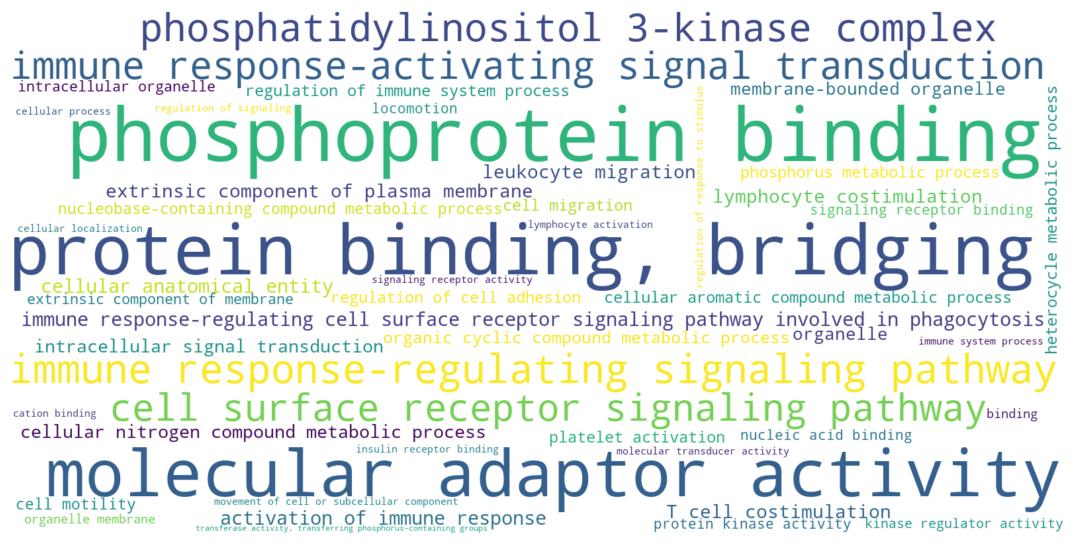

In [17]:
# max num of words to be drawn
N_max = 50

wc = draw_word_cloud(
    df = result[filter_terms],
    N = N_max,
    score = 'p-value',
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig("../../figures/GO_original.pdf")
plt.show()

<a id="architectures"></a>

# Architectures datasets

In [16]:
# file containing architectures datasets
ARCH_FILE_PATH = "../../datasets/architectures_datasets.json"

# read architectures
with open(ARCH_FILE_PATH) as f:
    arch_dataset = json.load(f)

In [17]:
# read the original dataset (hits retrieved by our model)
# it will be the background dataset
with open(ORIGINAL_DATASET) as f:
    bg_dataset = f.read().splitlines()

In [18]:
# count the anchestors for each sequence of the dataset
background_count = count_ancestors(bg_dataset, ancestors, protein_to_go)

In [19]:
# create a list of df, in each one of them there is the results

# consider only datasets containing at least MIN_SIZE sequences
MIN_SIZE = 4

results = {}
filtered_results = {}

for key in arch_dataset:
    
    current_dataset = arch_dataset[key]
    
    if len(current_dataset) > MIN_SIZE:
        print("Number of sequences in the current dataset: {}".format(
            len(current_dataset))
             )
    
        dataset_count = count_ancestors(current_dataset, ancestors, protein_to_go)

        # perform fisher exact test
        result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)
        result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

        # add depth and description columns
        result = add_depth_description(
            df = result_fisher,
            min_depth = min_depth, 
            labels = labels )

        results[key] = result
        
        # Bonferroni correction
        # adjust threshold based on the numbe of tests
        # http://www.biostathandbook.com/multiplecomparisons.html
        alpha = 0.05
        m = result.shape[0]
        adjusted_threshold = alpha/m
            
        # filter by depth
        filter_terms = (result["depth"] >= 1) & \
                       (result["depth"] <= 4) & \
                       (result["p-value"] <= adjusted_threshold)
        filtered_results[key] = result[filter_terms]

Number of sequences in the current dataset: 6
Number of sequences in the current dataset: 15
Number of sequences in the current dataset: 13
Number of sequences in the current dataset: 6


In [20]:
# selected architecures
list(results.keys())

['PF00017,PF00018', 'PF00017', 'PF00017,PF00018,PF07714', 'PF07525,PF00017']

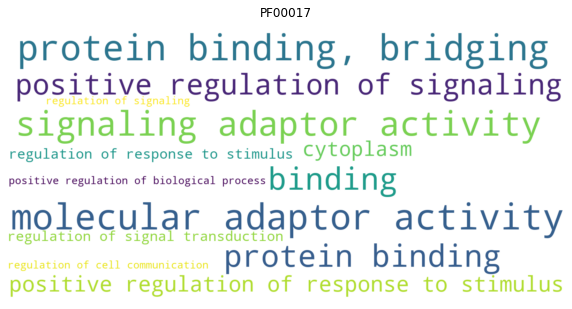

In [21]:
# draw wordcloud
for key in filtered_results:
    
    if filtered_results[key].shape[0] > 0:
    
        # Num of words to be drawn
        N = sum(filtered_results[key].OddRatio > 1)

        wc = draw_word_cloud(
            df = filtered_results[key],
            N = N,
            score = 'p-value',
            scale = 1,
            under_represented=False
        )

        # Plot
        plt.figure(figsize=(10, 10))
        plt.title(key)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

<a id="pdbnetwork"></a>

# PDB network dataset

In [22]:
# input dataset: pdb dataset
PDB_PATH = '../../datasets/pdb.cvs'

# read the pdb dataset (is a dataframe) 
dataset_df = pd.read_csv(PDB_PATH)

# get the list (unique) of proteins
dataset = dataset_df.sp_primary.unique()

### Create background dataset

In [23]:
from pdb_network import *

list_human = getListHumans(PATH_REFERENCE_DB)

# Import original dataset
original_proteins = []
with open(PATH_ORIGINAL_DB) as file:
    for line in file:
        original_proteins.append(line.strip())
        
# Import pdb - uniprot relation file
pdb_rel = pd.read_csv(PATH_PDB_UNIPROT_REL, sep = '\t', header = 1)
pdb_rel.columns = list(map(lambda x: x.lower(), pdb_rel.columns.values))

# Create background dataframe, all PDB proteins in swissprot
pdb_bg_df = pdb_rel.loc[
    pdb_rel.sp_primary.isin(list_human),
    ['pdb','sp_primary','chain','sp_beg','sp_end']
].copy()

There are 20367 human proteins in SwissProt


In [24]:
# get the list (unique) of proteins in swissprot with a PDB
bg_dataset = pdb_bg_df.sp_primary.unique()
print("There are {} human proteins with PDB in Swissprot".format(len(bg_dataset)))

There are 6756 human proteins with PDB in Swissprot


### Enrichment

In [25]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_go)

In [26]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [27]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [28]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
2001160,35.206277,0.004411,9,regulation of histone H3-K79 methylation
0071226,35.206277,0.004411,4,cellular response to molecule of fungal origin
0005943,35.206277,0.004411,5,"phosphatidylinositol 3-kinase complex, class IA"
0048408,35.206277,0.004411,3,epidermal growth factor binding
0032044,35.206277,0.004411,3,DSIF complex


In [29]:
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 1.3408420488066507e-05


In [30]:
# filter 
filter_terms = (result_fisher["depth"] >= 1) & (result_fisher["depth"] <= 3) \
               & (result_fisher["p-value"] <= adjusted_threshold)
#filter_terms = result_fisher["p-value"] <= adjusted_threshold
result[filter_terms].head()

,OddRatio,p-value,depth,label
0005942,17.607149,1.674237e-07,3,phosphatidylinositol 3-kinase complex
0051219,14.315494,1.521166e-19,3,phosphoprotein binding
0031295,11.991318,1.218308e-11,3,T cell costimulation
0031294,11.741485,1.582401e-11,2,lymphocyte costimulation
0002433,10.065512,5.261946e-13,3,immune response-regulating cell surface recept...


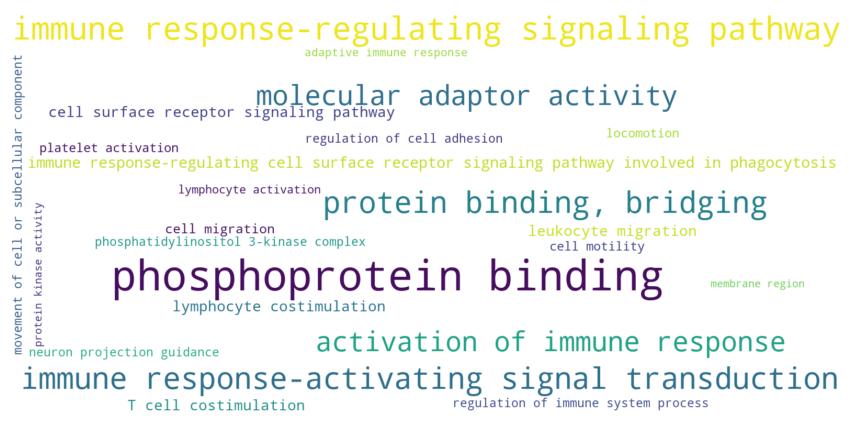

In [31]:
# Num of words to be drawn

wc = draw_word_cloud(
    df = result[filter_terms],
    N = sum(result[filter_terms].OddRatio > 1),
    N_under_represented = sum(result[filter_terms].OddRatio < 1),
    score = 'p-value',
    scale = 1.,
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<a id="string"></a>

# String dataset

In [32]:
# read the STRING dataset (proteins of the original dataset + all direct STRING interactors)
with open("../../datasets/string.txt") as f:
    dataset = f.read().splitlines()
print("There are {} proteins in the STRING dataset".format(len(dataset)))

There are 441 proteins in the STRING dataset


### Create background dataset

In [18]:
import requests

URL = "https://www.uniprot.org"

# All human proteins available in STRING and Swissprot
query = "database:(type:string) AND reviewed:yes AND organism:\"Homo sapiens (Human) [9606]\"&format=list"
r = requests.get("{}/uniprot/?query={}".format(URL, query))

In [19]:
bg_dataset = r.text.strip().split("\n")
print("There are {} human proteins available in STRING and Swissprot".format(len(bg_dataset)))

There are 18561 human proteins available in STRING and Swissprot


### Enrichment

In [20]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_go)

In [21]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [22]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [23]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0033277,99.953512,0.000581,4,abortive mitotic cell cycle
0035685,99.953512,0.000581,4,helper T cell diapedesis
1900235,99.947245,0.019715,7,negative regulation of Kit signaling pathway
1904618,99.947245,0.019715,6,positive regulation of actin binding
0001545,99.947245,0.019715,2,primary ovarian follicle growth


In [24]:
alpha = 0.05
m = result.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 1.9297568506368197e-05


In [57]:
# filter by depth
filter_terms = (result["depth"] >= 0) & (result["depth"] <=4) \
               & (result["p-value"] <= adjusted_threshold)
result[filter_terms].head(10)

,OddRatio,p-value,depth,label
0035014,66.677229,6.525987e-17,4,phosphatidylinositol 3-kinase regulator activity
0045309,55.837023,3.665615e-37,4,protein phosphorylated amino acid binding
0050904,49.979795,7.808898e-05,3,diapedesis
0005942,44.451233,2.717016e-15,3,phosphatidylinositol 3-kinase complex
0051219,36.953562,3.475250e-35,3,phosphoprotein binding
0035591,34.367431,1.308345e-38,4,signaling adaptor activity
0046875,33.332087,6.782147e-11,4,ephrin receptor binding
0005159,31.241131,1.700007e-06,4,insulin-like growth factor receptor binding
0097696,25.803786,4.334302e-09,4,receptor signaling pathway via STAT
0038096,25.012616,1.610523e-18,4,Fc-gamma receptor signaling pathway involved i...


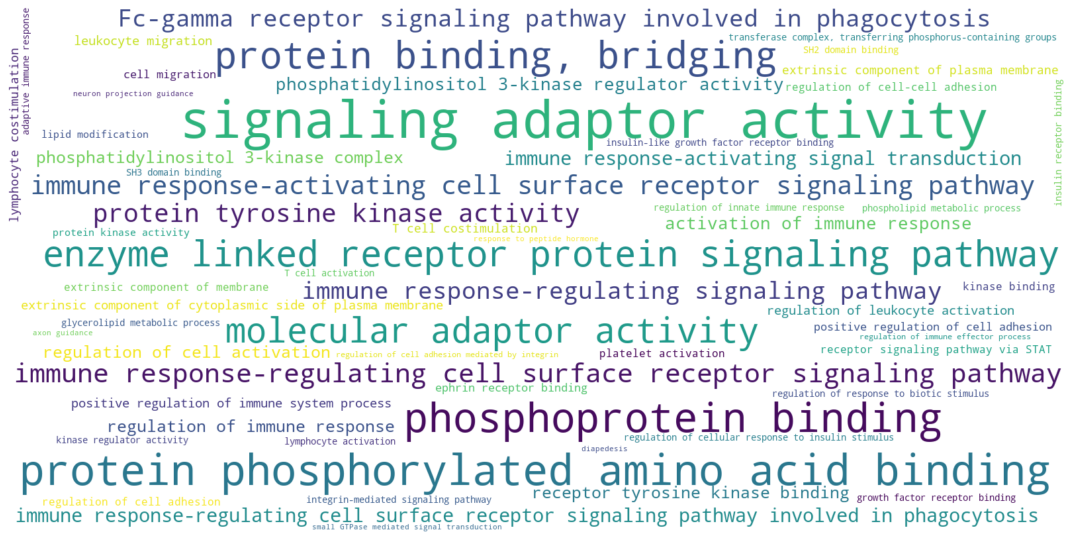

In [67]:
# max num of words to be drawn
N_max = 60

wc = draw_word_cloud(
    df = result[filter_terms],
    N = N_max,
    score = 'p-value',
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig("../../figures/GO_string.pdf")
plt.show()